### **Aplicacion de clustering para dataset de clientes**

Se utiliza un dataset con datos de clientes. El conjunto de datos se refiere a clientes de un distribuidor mayorista. Incluye el gasto anual en unidades monetarias (u.m.) en diversas categorías de productos.

El dataset se encuentra disponible en Kaggle: https://www.kaggle.com/datasets/binovi/wholesale-customers-data-set

### **1. Importación de librerias y dataset**

Se importan las librerias a ser utilizadas y el dataset a analizar

In [1]:
# librerias 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors
# cluster
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import DBSCAN
# reduccion
from sklearn.decomposition import PCA

In [3]:
# importar el dataset 
df = pd.read_csv('Wholesale customers data.csv')
df.head(5)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


### **2. Limpieza de datos**

En esta sección se verifica la presencia de valores duplicados, outliers, nulos en el dataset con los datos de entrenamiento

### **2.1. Verificacion de tipo de datos**

In [4]:
# info del df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


Los datos del dataset son del tipo numerico.

### **2.2. Verificacion de valores duplicados**

Se procede a verificar si hay datos duplicados.



In [5]:
# identificar duplicados
duplicados = df.duplicated()

# contar el número de duplicados
num_duplicados = duplicados.sum()
print(f"Número de registros duplicados: {num_duplicados}")

Número de registros duplicados: 0


El dataset no contiene datos duplicados.


### **2.3. Análisis de los valores faltantes**

Se verifica la cantidad y porcentaje de valores faltantes en el dataframe, además de ser necesario se rellenan los datos faltantes.

In [6]:
# identificacion de datos faltantes con funcion proporcionada en clase
# cantidad de datos completos, sin NA, es decir, el total de datos
qsna=df.shape[0]-df.isnull().sum(axis=0)

# cantidad de datos que si son na
qna=df.isnull().sum(axis=0)

# proporcion de datos con na y sin na
ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)

# constuir la tab
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)

# filtrar solo los que tienen NA
na = na[na['Na en q'] > 0]

# ordenar los valores de la tabla
na.sort_values(by='Na en %',ascending=False)

,datos sin NAs en q,Na en q,Na en %


No hay valores faltantes en el dataset.

### **3. Exploracion de datos**

Crear histogramas y boxplots para las variables

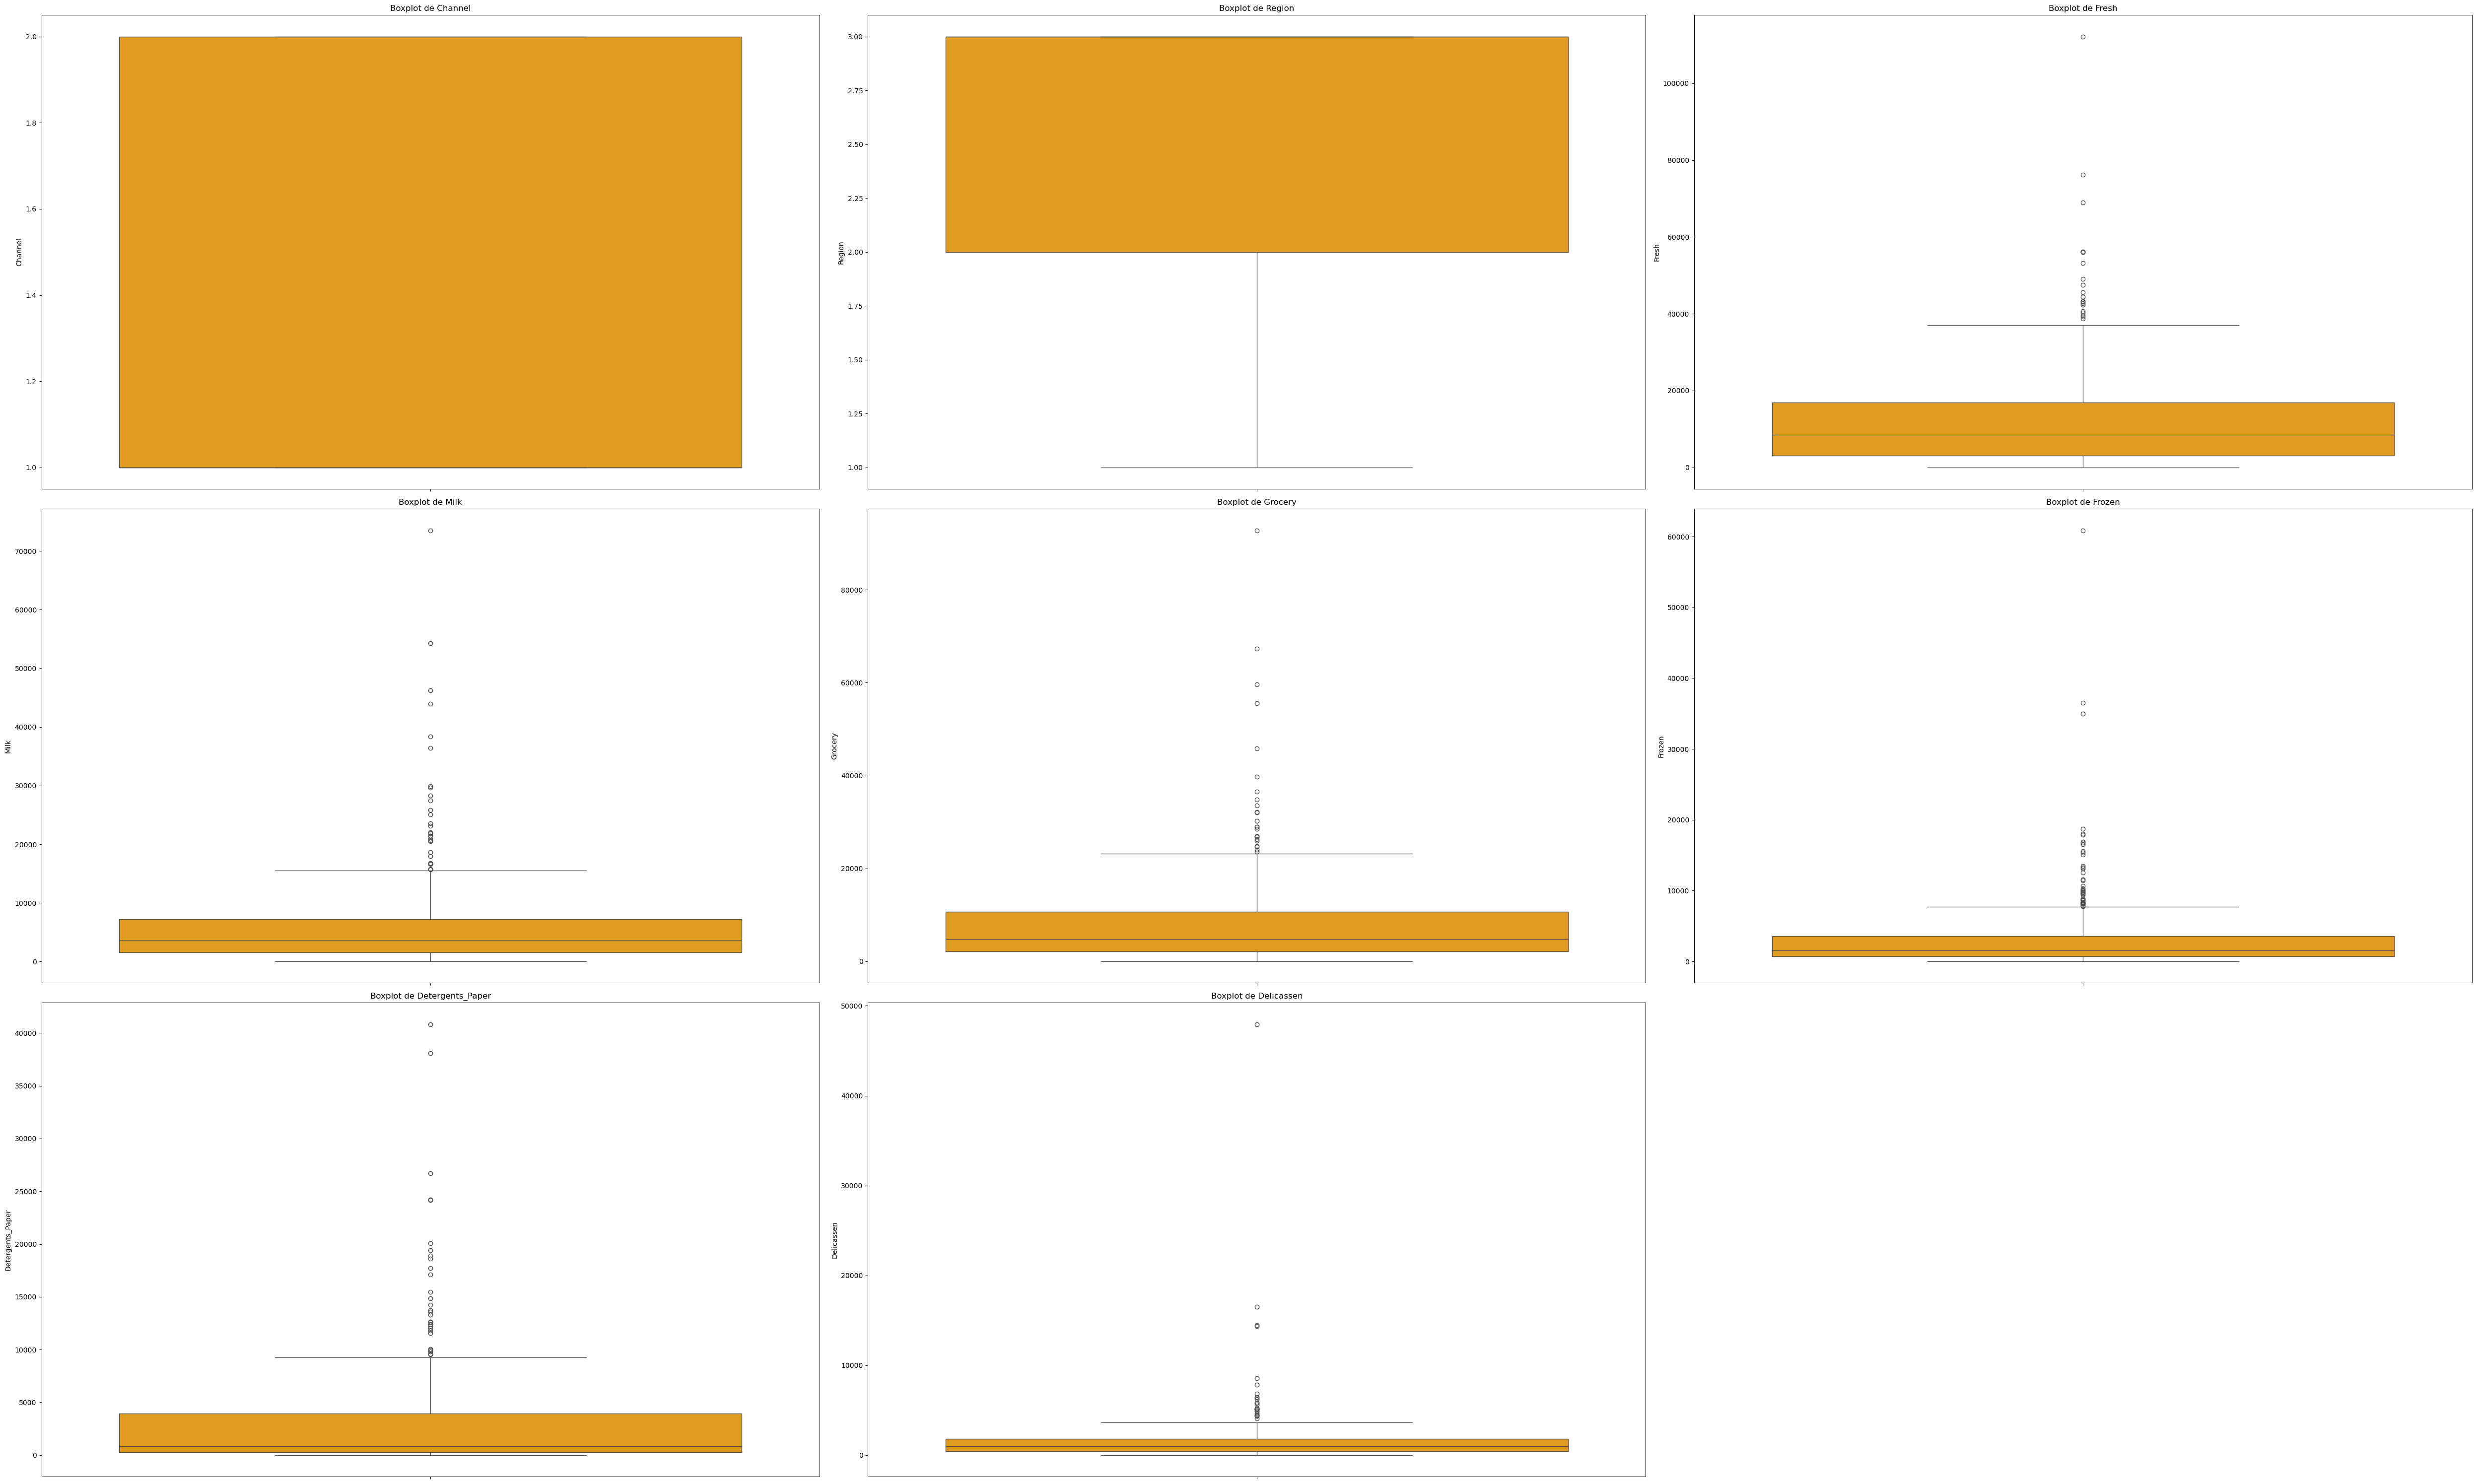

In [8]:
# extraer columnas numericas 
numerical_columns = df.select_dtypes(include=['int', 'float']).columns

# numero de columnas y filas
cols = 3
filas = (len(numerical_columns) // cols) + (len(numerical_columns) % cols > 0)

# crear boxplots 
plt.figure(figsize=(50, 30))
for i, col in enumerate(numerical_columns, 1):
    # ajusta segun la cantidad de columnas
    plt.subplot(filas, cols, i) 
    sns.boxplot(y=df[col], color="orange")
    plt.title(f"Boxplot de {col}")
    plt.tight_layout()

plt.show()

En los boxplots se logran visualizar muchos outliers. 

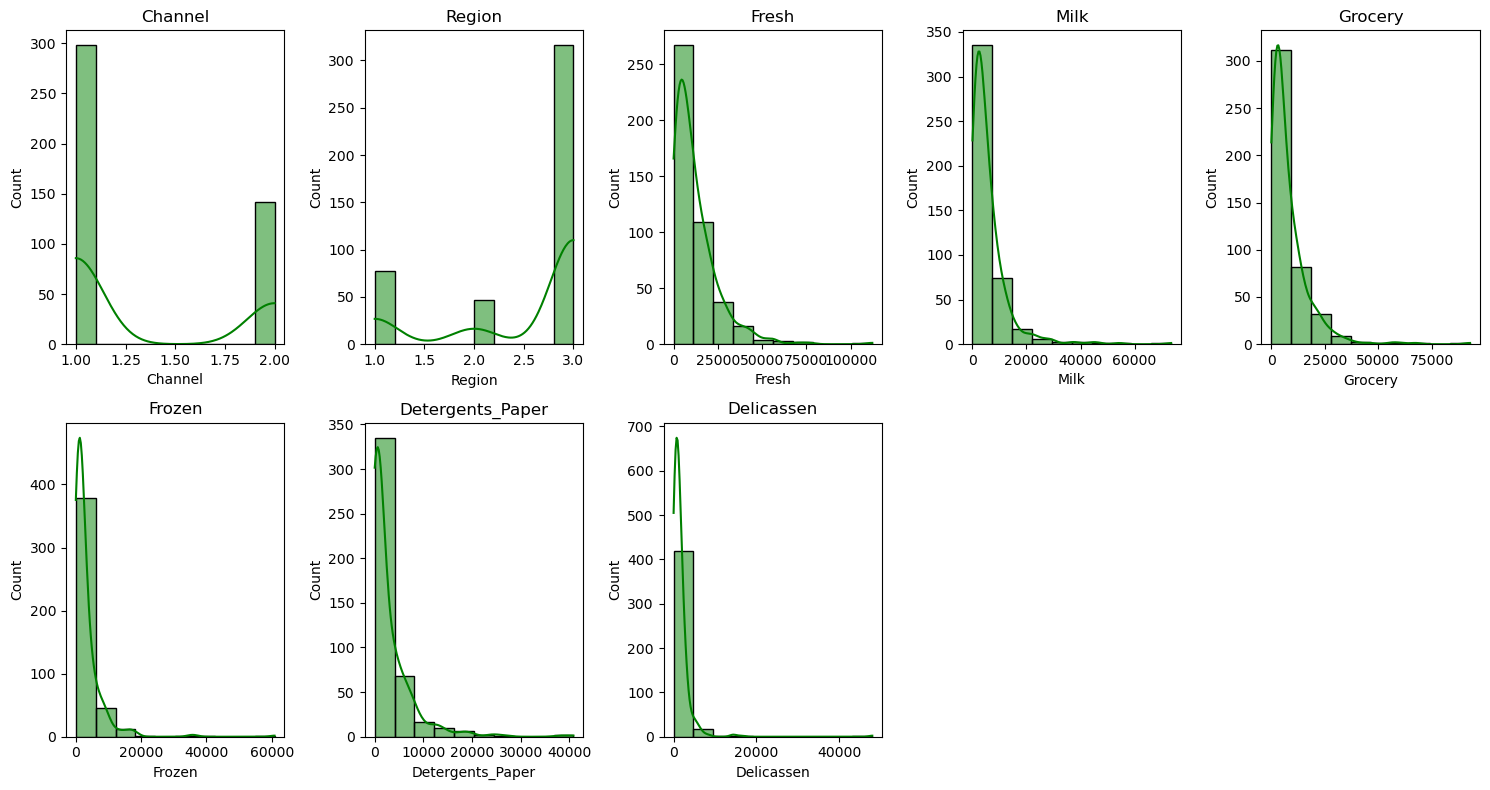

In [9]:
# distribucion de los datos
plt.figure(figsize=(15, 8))

# numero de columnas y filas
cols = 5
filas = (len(numerical_columns) // cols) + (len(numerical_columns) % cols > 0)

for i, col in enumerate(numerical_columns, 1):
    # ajusta segun la cantidad de columnas
    plt.subplot(filas, cols, i)  
    sns.histplot(df[col], kde=True, color="green", bins=10)  
    plt.title(f"{col}")
    plt.tight_layout()

plt.show()

In [10]:
# describe
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


A continuacion se grafica un mapa de calor para identificar correlaciones.

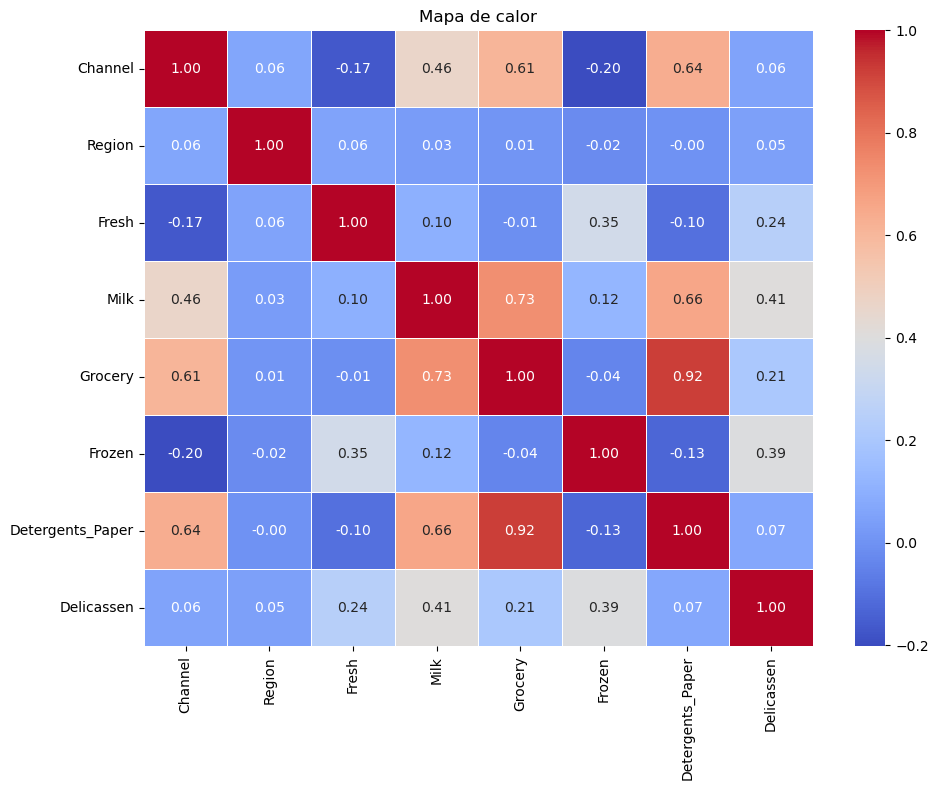

In [12]:
# variables numéricas
numerical_columns = df.select_dtypes(include=['int','float'])

# matriz de correlación
correlation_matrix = numerical_columns.corr(method="pearson")

# mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Mapa de calor')
plt.tight_layout()
plt.show()

### **4. Aplicacion de DBSCAN**

Se aplicara el metodo de cluster utilzando dbscan

In [16]:
# df
df.head(5)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [18]:
# columnas relevantes
columns_selected = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

df_selected = df[columns_selected] 

In [19]:
# estandarizar los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)

In [20]:
# aplicar DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  
dbscan.fit(df_scaled)

DBSCAN()

In [21]:
# obtener las etiquetas de los clusters
labels = dbscan.labels_

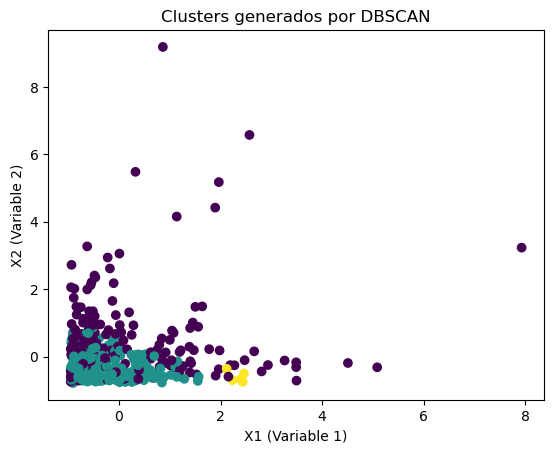

In [22]:
# visualización de los clusters
plt.scatter(df_scaled[:, 0], df_scaled[:, 1], c=labels, cmap='viridis')
plt.title("Clusters generados por DBSCAN")
plt.xlabel("X1 (Variable 1)")
plt.ylabel("X2 (Variable 2)")
plt.show()

Se busca mejorar los parametros de DBSCAN

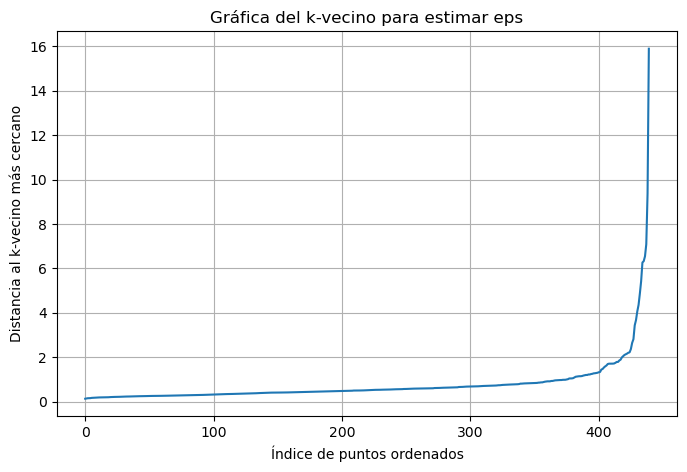

In [23]:
# configurar min_samples
min_samples = 5

# ajustar el modelo de k-vecino más cercano
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(df_scaled)
distances, indices = nbrs.kneighbors(df_scaled)

# ordenar las distancias
distances = np.sort(distances[:, -1])

# graficar las distancias para estimar eps
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title('Gráfica del k-vecino para estimar eps')
plt.xlabel('Índice de puntos ordenados')
plt.ylabel('Distancia al k-vecino más cercano')
plt.grid()
plt.show()

Se aplican las mejoras para DBSCAN 

In [32]:
# aplicar DBSCAN
dbscan = DBSCAN(eps=2, min_samples=5)  
dbscan_labels = dbscan.fit_predict(df_scaled)

In [33]:
# agregar las etiquetas de los clusters al df
df['Cluster'] = dbscan_labels

In [34]:
# identificar outliers 
outliers = df[df['Cluster'] == -1]

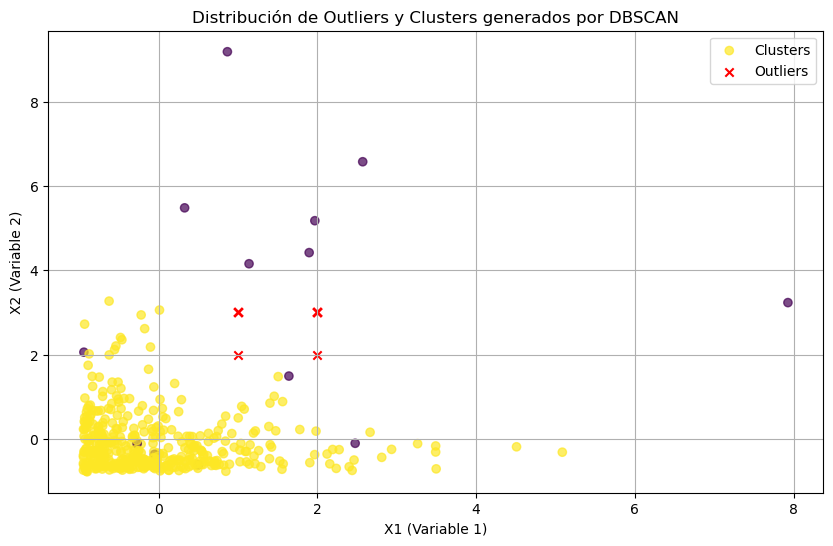

Outliers identificados:
     Channel  Region   Fresh   Milk  Grocery  Frozen  Detergents_Paper  \
23         2       3   26373  36423    22019    5154              4337   
47         2       3   44466  54259    55571    7782             24171   
61         2       3   35942  38369    59598    3254             26701   
65         2       3      85  20959    45828      36             24231   
71         1       3   18291   1266    21042    5373              4173   
85         2       3   16117  46197    92780    1026             40827   
86         2       3   22925  73498    32114     987             20070   
87         1       3   43265   5025     8117    6312              1579   
93         1       3   11314   3090     2062   35009                71   
181        1       3  112151  29627    18148   16745              4948   
183        1       3   36847  43950    20170   36534               239   
325        1       2   32717  16784    13626   60869              1272   
333        2  

In [36]:
# visualizar los clusters
plt.figure(figsize=(10, 6))
plt.scatter(df_scaled[:, 0], df_scaled[:, 1], c=dbscan_labels, cmap='viridis', label='Clusters', alpha=0.7)

# resaltar los outliers
plt.scatter(outliers.iloc[:, 0], outliers.iloc[:, 1], color='red', label='Outliers', marker='x')

# grafico
plt.title("Distribución de Outliers y Clusters generados por DBSCAN")
plt.xlabel("X1 (Variable 1)")
plt.ylabel("X2 (Variable 2)")
plt.legend()
plt.grid()
plt.show()

# mostrar los outliers identificados
print("Outliers identificados:")
print(outliers)

Se visualizan los clusters generados por DBSCAN y los outliers. Los outliers se identifican con -1 en DBSCAN.

In [37]:
# aplicar PCA 
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

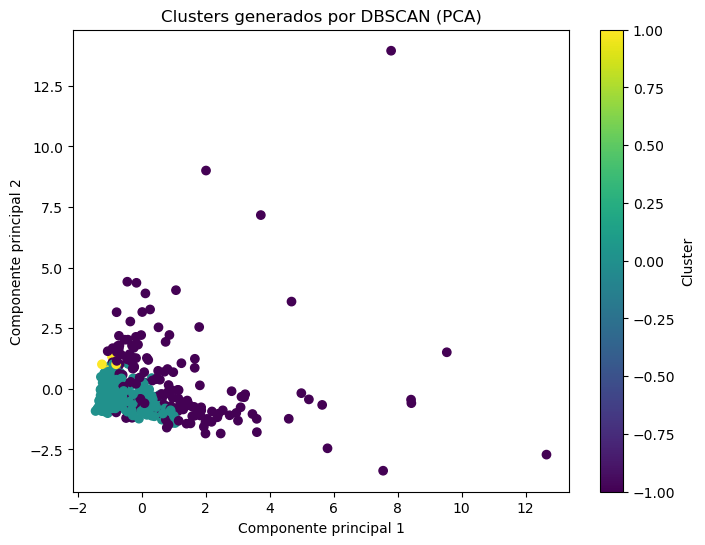

In [38]:
# grafico
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap='viridis')
plt.title("Clusters generados por DBSCAN (PCA)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.colorbar(label='Cluster')
plt.show()

Para este caso se aplico DBSCAN al conjunto de datos y posteriormente se aplico PCA para reducir a dos componentes principales. 

In [39]:
# calcular el Silhouette Score del modelo
dbscan_silhouette = silhouette_score(df_scaled, dbscan_labels)

# Calcular el Calinski-Harabasz Index para los modelos
dbscan_calinski = calinski_harabasz_score(df_scaled, dbscan_labels)

# imprimir
print("DBSCAN Silhouette Score:", dbscan_silhouette)
print("DBSCAN Calinski-Harabasz Index:", dbscan_calinski)

DBSCAN Silhouette Score: 0.7486988127438182
DBSCAN Calinski-Harabasz Index: 110.37062341675326


Se tienen los siguientes parametros, para siluete se tiene 0.74, lo que indica que los clusters estan bien definidos. Por otro lado, CH da un valor de 0.74 sugiere que los clusters estan bien separados y definidos. 

indicadores muestran que el modelo DBSCAN ha logrado una buena formación de clústeres, con una separación clara entre los mismos.